---

<h2 style="text-align: center;"><b>Свёрточные нейронные сети: MNIST</b></h3>

---

Выполнил - Пермяшкин Дмитрий, гр. 20223

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [13]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
from itertools import product, compress

Скачаем и загрузим данные в `DataLoader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [3]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [4]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Посмотрим, как она выглядит:

In [5]:
# преобразовать тензор в np.array
def show_picture(img_data):
  npimg = img_data.numpy()
  plt.imshow(npimg, cmap='gray')
  plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


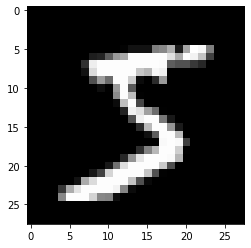

In [6]:
show_picture(trainloader.dataset.train_data[0])

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй я уже хорошенько разобрались в популярных в последнее время задачках на CTF, теперь время использовать именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

Заметим, что нам очень повезло, и фактически надо перебрать только (число каналов, число сверточных слоев, тип пулинга, активация, число полносвязных слоев). Почему повезло? В теории потому что параметров намного больше. А так можно спокойно не парится на тему "а надо ли пулинг на этой итерации", кучу параметров самого пулинга...

**Важное примечание:** *лайфхак* не помогает никак, если построение сети надо делать автоматически или полуавтоматически. И будем честны - делать это ручками просто +1 причина подумать о том, а нужен ли pytorch, ибо инструмент не должен добавлять сверху проблем. Ну или хотя бы давать утилиты, если прижмет.

Но считать ручками тоже лень, поэтому... время *лайфхака*

In [39]:
def layer_output_shape(layer, shape):
    return layer(torch.rand(*(shape))).data.shape

class SimpleConvNet(nn.Module):
    def __init__(self, extractor_config, pooling_layer, classificator_config, activation_func=F.relu):
        super().__init__()

        self.activation = activation_func
        base_shape = (1,1,28,28)

        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(in_channels=1, out_channels=extractor_config[0], kernel_size=5))
        self.pool = pooling_layer
        base_shape = layer_output_shape(self.pool, layer_output_shape(self.conv[-1],base_shape))

        for i in range(0,len(extractor_config)-1):
          self.conv.append(nn.Conv2d(in_channels=extractor_config[i], out_channels=extractor_config[i+1], kernel_size=5))
          base_shape = layer_output_shape(self.pool, layer_output_shape(self.conv[-1],base_shape))
        
        self.extractor_shape = base_shape[1]*base_shape[2]*base_shape[3]
        self.fc = nn.ModuleList()
        real_config = [self.extractor_shape] + classificator_config + [10]
        for i in range(0, len(real_config)-1):
          self.fc.append(nn.Linear(real_config[i],real_config[i+1]))


    def forward(self, x):
        for c_layer in self.conv:
          x = self.pool(self.activation(c_layer(x)))
        x = x.view(-1, self.extractor_shape) 

        for l_layer in self.fc[:-1]:
          x = self.activation(l_layer(x))
        x = self.fc[-1](x)
        return x

Функции для обучения сети и проверки через accuracy_score

In [8]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

def train(network, epoches):
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  losses = []
  for epoch in tqdm.notebook.tqdm(range(epoches)):
    for X_batch, y_batch in trainloader:
      optimizer.zero_grad()

      y_pred = network(X_batch)
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()

  return losses

def test(network):
  class_correct = [0.]*10
  class_total = [0.]*10
  class_result = [0.]*10

  with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
  
  for i in range(10):
    class_result[i] = class_correct[i] / class_total[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_result[i]))
  
  return class_result

In [44]:
best = [(None,0.)]*10
the_best = (None, 0.)

# Сверточные слои

Стоит отметить, что конфигурация выбрана в сторону расширения числа канала, поскольку сейчас мы "расширяем" данные новыми признаками. 

Число эпох и возможных каналов подобрано, чтобы не отключало от машины за "слишком долго считать".

In [47]:
layers = [5,10,15,20]
for l in tqdm.notebook.tqdm([list(compress(layers,w)) for w in list(product([0,1],repeat=4))[1:]]):
  print("Extraction layer channel config", l)
  try:
    net = SimpleConvNet(l,nn.MaxPool2d(kernel_size=2, stride=2), [120,84])
    losses = train(net,3)
    result = test(net)
    average = 0.
    for i in range(10):
      if result[i] > best[i][1]:
        best[i] = (net, result[i])
      average += result[i]
    average /= 10
    if average > the_best[1]:
      the_best = (net,average)
  except RuntimeError:
    print("Impossible configuration")
  finally:
    print()

  0%|          | 0/15 [00:00<?, ?it/s]

Extraction layer channel config [20]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 96 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %

Extraction layer channel config [15]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 97 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 96 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %

Extraction layer channel config [15, 20]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %

Extraction layer channel config [10]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 94 %
Accuracy of     9 : 97 %

Extraction layer channel config [10, 20]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 96 %
Accuracy of     4 : 96 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %

Extraction layer channel config [10, 15]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 96 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %

Extraction layer channel config [10, 15, 20]
Impossible configuration

Extraction layer channel config [5]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 97 %
Accuracy of     4 : 97 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 97 %
Accuracy of     8 : 95 %
Accuracy of     9 : 96 %

Extraction layer channel config [5, 20]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %

Extraction layer channel config [5, 15]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 95 %
Accuracy of     5 : 97 %
Accuracy of     6 : 97 %
Accuracy of     7 : 96 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %

Extraction layer channel config [5, 15, 20]
Impossible configuration

Extraction layer channel config [5, 10]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 94 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %

Extraction layer channel config [5, 10, 20]
Impossible configuration

Extraction layer channel config [5, 10, 15]
Impossible configuration

Extraction layer channel config [5, 10, 15, 20]
Impossible configuration



Выведем для каждого класса лучшую сеть и с лучшей средней точностью (усреднение accuracy_score по классам равномерное - слишком малый датасет для анализа распределения классов)

In [51]:
for i in range(10):
  print("Best network for class %5s with score %2d %%" % (classes[i],100*best[i][1]))
  print(best[i][0])

print("Best network on average")
print(the_best[0])

Best network for class     0 with score 99 %
SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): ModuleList(
    (0): Linear(in_features=320, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
Best network for class     1 with score 99 %
SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): ModuleList(
    (0): Linear(in_features=2880, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
Best network for class     2 with score 99 %
SimpleConvNet(
  (c

Ну тут очевидная проблема того, что многослойный экстрактор просто рано или поздно сведет картинку к 1х1. Вдобавок даже однослойный с презаданным классификатором решает задачу неплохо, поэтому речь идет обычно о sub1% улучшениях.

# Подбор типа пулинга

Можно было сделать минимум или хитрые схемы, но в большей части работ советуют либо среднее, либо пик брать. Поэтому 2 типа всего.

In [55]:
for p in tqdm.notebook.tqdm([nn.MaxPool2d(kernel_size=2, stride=2),nn.AvgPool2d(kernel_size=2, stride=2)]):
  print("Pooling type", str(p))
  try:
    net = SimpleConvNet([15,20],p, [120,84])
    losses = train(net,3)
    result = test(net)
    average = 0.
    for i in range(10):
      if result[i] > best[i][1]:
        best[i] = (net, result[i])
      average += result[i]
    average /= 10
    if average > the_best[1]:
      the_best = (net,average)
  except RuntimeError:
    print("Impossible configuration")
  finally:
    print()

  0%|          | 0/2 [00:00<?, ?it/s]

Pooling type MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 97 %

Pooling type AvgPool2d(kernel_size=2, stride=2, padding=0)


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 97 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 94 %
Accuracy of     9 : 95 %



По итогу оба типа выдают примерно одинаковый результат, но для данной задачи выбор пиков оказывается немного лучше.

# Функция активации

In [56]:
for act in tqdm.notebook.tqdm([nn.functional.relu,nn.functional.elu, torch.sigmoid, nn.functional.softsign, torch.tanh]):
  print("Activation func", str(act))
  try:
    net = SimpleConvNet([15,20],nn.MaxPool2d(kernel_size=2, stride=2) , [120,84],activation_func=act)
    losses = train(net,3)
    result = test(net)
  except RuntimeError:
    print("Impossible configuration")
  finally:
    print()

  0%|          | 0/5 [00:00<?, ?it/s]

Activation func <function relu at 0x7f69f1947ef0>


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 96 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %

Activation func <function elu at 0x7f69f194f0e0>


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %

Activation func <built-in method sigmoid of type object at 0x7f6aee7c31a0>


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 96 %
Accuracy of     4 : 96 %
Accuracy of     5 : 96 %
Accuracy of     6 : 97 %
Accuracy of     7 : 95 %
Accuracy of     8 : 93 %
Accuracy of     9 : 92 %

Activation func <function softsign at 0x7f69f194f710>


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %

Activation func <built-in method tanh of type object at 0x7f6aee7c31a0>


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %



Ну вот тут видно, что хоть функции примерно дают схожий результат (кроме сигмоиды, что логично), но ReLU теперь не лучший выбор.

Поэтому далее будет использована softsign (поправлено "за кадром", поскольку надо было поправить ещё один баг, а перезапускать 3х часовой лист не хотелось).

# Число полносвязных слоев

Вот тут уже конфигурация по сужению, поскольку все признаки уже выделились на предыдущем шагу. Плюсом вся сверточность придумана как раз с целью ужатия числа нейронов в полносвязном слое, поэтому расширение размера слоя может привести к возврату на поле "с чего начинали".

Опять параметры упираются в ограничения бесплатного аккаунта.

In [57]:
l_layers = [256,128,64,32]
for l in tqdm.notebook.tqdm([list(compress(l_layers,w)) for w in list(product([0,1],repeat=4))[1:]]):
  print("Classificator layers config", l)
  try:
    net = SimpleConvNet([15,20],nn.MaxPool2d(kernel_size=2, stride=2), l)
    losses = train(net,3)
    result = test(net)
    average = 0.
    for i in range(10):
      if result[i] > best[i][1]:
        best[i] = (net, result[i])
      average += result[i]
    average /= 10
    if average > the_best[1]:
      the_best = (net,average)
  except RuntimeError:
    print("Impossible configuration")
  finally:
    print()

  0%|          | 0/15 [00:00<?, ?it/s]

Classificator layers config [32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 95 %
Accuracy of     4 : 97 %
Accuracy of     5 : 99 %
Accuracy of     6 : 97 %
Accuracy of     7 : 95 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %

Classificator layers config [64]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 97 %

Classificator layers config [64, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 95 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 94 %

Classificator layers config [128]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 96 %

Classificator layers config [128, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 96 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 94 %

Classificator layers config [128, 64]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 97 %

Classificator layers config [128, 64, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %

Classificator layers config [256]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 96 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 99 %

Classificator layers config [256, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %

Classificator layers config [256, 64]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %

Classificator layers config [256, 64, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 95 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 96 %
Accuracy of     8 : 99 %
Accuracy of     9 : 94 %

Classificator layers config [256, 128]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 97 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %

Classificator layers config [256, 128, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %

Classificator layers config [256, 128, 64]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %

Classificator layers config [256, 128, 64, 32]


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %



In [58]:
for i in range(10):
  print("Best network for class %5s with score %2d %%" % (classes[i],100*best[i][1]))
  print(best[i][0])

print("Best network on average")
print(the_best[0])

Best network for class     0 with score 99 %
SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(15, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): ModuleList(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)
Best network for class     1 with score 99 %
SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(15, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): ModuleList(
    (0): Linear(in_features=320, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)
Best network for class     2 with score 99 %
SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 15, kernel_size=(5, 5), str

Неожиданно - но базовая конфигурация линейного слоя (из данного в условии notebook) оказывается лучше в среднем. Если смотреть по классам, то есть места, где другие конфигурации выигрывают, но они в основном двуслойные. Это выходит из того, что из ч/б картинки 28х28 с одной фигурой классическая структура CNN не может выжать слишком много признаков.

Ну и ещё из того, что все сети прыгают в основном вокруг 97-99% точности, поэтому сложно отличить более удачную конфигурацию начальных весов и улучшение структуры.

# Итог

Лучшая нейросеть из рассмотренных

In [59]:
the_best[0]

SimpleConvNet(
  (conv): ModuleList(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(15, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): ModuleList(
    (0): Linear(in_features=320, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

Её accuracy_score

In [61]:
_ = test(the_best[0])

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %
